In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xmitgcm import open_mdsdataset
from MITgcmutils import rdmds,wrmds
import rosypig as rp
import pych
import pych.ecco as pe
import pych.pigmachine as pm
import pych.pigmachine.matern as matern

In [2]:
fig_dir = 'figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [3]:
plt.style.use('./correlation.mplstyle')

In [53]:
NxList = [10, 20]
xiList = [.5,1,2]
#omegaList = [0.8, 0.9, 1.0,1.02,1.04,1.06,1.08,1.1,1.2,1.3,1.4,1.5,1.6,1.7]
omegaList = [0.8, 0.9, 1.0,1.1,1.2,1.3,1.35,1.4,1.5,1.6,1.7]
main_dir = '/scratch2/tsmith/generic-matern-covariance/sampling/llc90/sor-parameter-test/'

In [54]:
omegaLabels = [r'SOR $\omega$=%.1f' % x for x in omegaList]

In [55]:
nxdict = {}
which_jacobi='3D'
which2d = slice(None,1000)
for Nx in NxList:
    xidict = {}
    for xi in xiList:
        iters={}
        for omega in omegaList:
            myiters = pych.read_jacobi_iters(f'{main_dir}/sor-3D-{omega}-C/run.{Nx:02d}dx.{xi:02}xi/STDOUT.0000',
                                             which_jacobi=which_jacobi)
            if which_jacobi=='2D' or which_jacobi=='3D':
                myiters=myiters[which2d]
            iters[omega] = myiters
        xidict[xi] = iters
    nxdict[Nx]=xidict

In [56]:
allmeansnx = {}
for omega in omegaList:
    allmeansxi={}
    for xi in xiList:
        omega_mean=[]
        for Nx in NxList:
            iters = nxdict[Nx][xi]
            omega_mean.append(np.nanmean(iters[omega]))
        allmeansxi[xi]=np.array(omega_mean)
    allmeansnx[omega] = allmeansxi


<ipython-input-56-7b7df1e120b7>:8: RuntimeWarning: Mean of empty slice
  omega_mean.append(np.nanmean(iters[omega]))


In [57]:
xiallmeans = {}
for omega in omegaList:
    nxallmeans={}
    for Nx in NxList:
        omega_mean=[]
        for xi in xiList:
            iters = nxdict[Nx][xi]
            omega_mean.append(np.nanmean(iters[omega]))
        nxallmeans[Nx]=np.array(omega_mean)
    xiallmeans[omega] = nxallmeans

<ipython-input-57-896add457f0a>:8: RuntimeWarning: Mean of empty slice
  omega_mean.append(np.nanmean(iters[omega]))


In [58]:
sormean ={}
for Nx in NxList:
    sorallmeans = {}
    for xi in xiList:
        omega_mean = []
        for omega in omegaList:
            iters = nxdict[Nx][xi]
            omega_mean.append(np.nanmean(iters[omega]))
        sorallmeans[xi]=np.array(omega_mean)
    sormean[Nx] = sorallmeans

<ipython-input-58-13fc3406d98f>:8: RuntimeWarning: Mean of empty slice
  omega_mean.append(np.nanmean(iters[omega]))


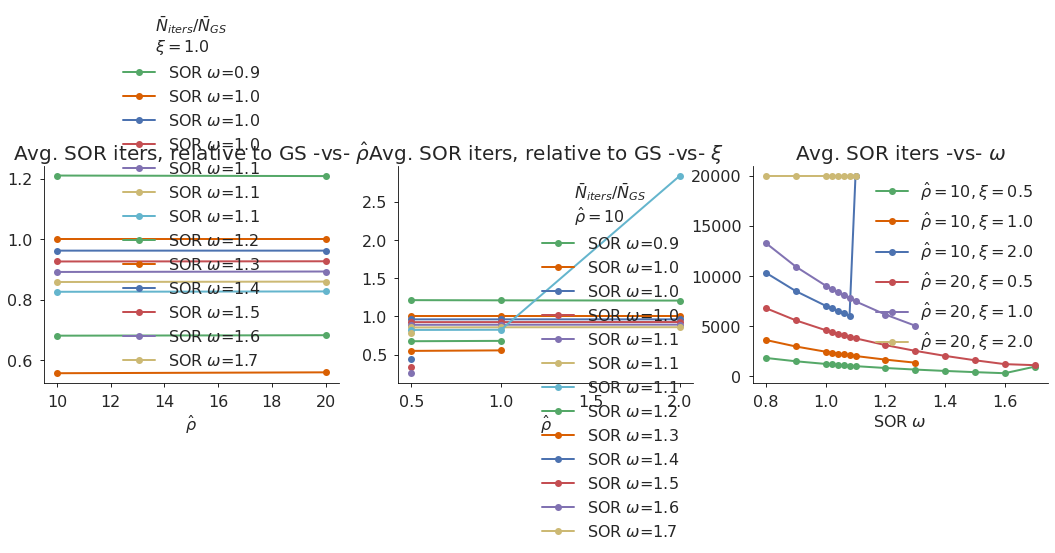

In [12]:
fig,axs = plt.subplots(1,3,figsize=(18,4))
xiSelect = 1
NxSelect = 10
for omega,lbl in zip(omegaList[1:],omegaLabels[1:]):
    
    # just showing relative to jacobi case
    #p=axs[0].plot(np.array(NxList),allmeans[omega],label=lbl,marker='o')
    for xi in [xiSelect]:
        axs[0].plot(np.array(NxList),allmeansnx[omega][xi]/allmeansnx[1][xi],
                    label=lbl,marker='o')
    for Nx in [NxSelect]:
        axs[1].plot(np.array(xiList),xiallmeans[omega][Nx]/xiallmeans[1][Nx],
                    label=lbl,marker='o')
for Nx in NxList: 
    for xi in xiList:
        axs[2].plot(np.array(omegaList),sormean[Nx][xi],label=r'$\hat{\rho}=%02d, \xi=%.1f$'%(Nx,xi),marker='o')
    
axs[0].legend(title=r'$\bar{N}_{iters}$')
axs[0].legend(title=r'$\bar{N}_{iters} / \bar{N}_{GS}$%s$\xi=$%.1f' % ('\n',xiSelect))
axs[1].legend(title=r'$\bar{N}_{iters} / \bar{N}_{GS}$%s$\hat{\rho}=$%02d' % ('\n',NxSelect))
axs[2].legend()
[ax.set(xlabel=r'$\hat\rho$') for ax in axs[:2]];
axs[2].set(xlabel=r'SOR $\omega$')
axs[0].set(title=r'Avg. iters -vs- $\hat\rho$')
axs[0].set(title=r'Avg. SOR iters, relative to GS -vs- $\hat\rho$')
axs[1].set(title=r'Avg. SOR iters, relative to GS -vs- $\xi$')
axs[2].set(title='Avg. SOR iters -vs- $\omega$');
#fig.savefig('sor_noXi.png',dpi=300,bbox_inches='tight')

Looks like optimal omega is

```
xi=0.5, omega = 1.6
xi=1.0, omega = 1.3
xi=2.0, omega = 1.06
```

Could maybe do 1.08 on xi=2 but going conservative...

### Nicer plot...

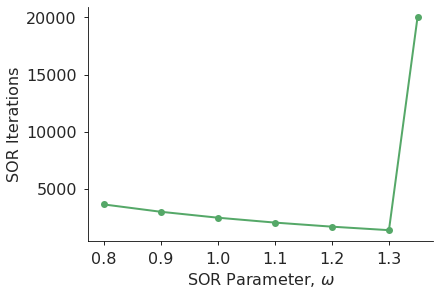

In [69]:
fig, ax = plt.subplots(1,1,
                       figsize=(6,4),
                        constrained_layout=True)

Nx = 10
xi = 1

label = r'$\hat{\rho}=%02d$'%Nx
ax.plot(np.array(omegaList),sormean[Nx][xi],
        label=label,
        marker='o')
#ax.legend(title=r'$\xi =%.1f$' % xi)
ax.set(ylabel='SOR Iterations',
       xlabel='SOR Parameter, $\omega$')
fig.savefig(f'{fig_dir}/sor_parameter.pdf', bbox_inches='tight')